# Water Stress Outlook from last 90 days GPM-IMERG percentiles of scores and C3S MME probabilistic forecast 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib

In [3]:
# %matplotlib widget
%matplotlib inline

### os 
import os 
import sys

### datetimes 
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from calendar import month_name, month_abbr, monthrange
import dateparser

### scipy 
import numpy as np 
import pandas as pd
import xarray as xr
from cartopy import crs as ccrs

### plotting 
from matplotlib import pyplot as plt

In [4]:
import pathlib

HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd() 

In [5]:
sys.path.append('../../') 

In [6]:
from ICU_Water_Watch import geo, C3S, domains, plot

### parameters for papermill

In [7]:
provider = 'CDS' # should not change 
domain_name = 'Water_Watch' # domain name for plotting, see `domains` module
period = "seasonal" # period for the forecast, 'monthly' or 'seasonal'
lag = 1 # lag with respect to current month for the C3S MME forecasts initial month
lead = 1 # lead time (month or season), should always stay at 1
ndays = 90 # accumulation period for the GPM-IMERG percentiles of score
quantile = 'quartile' # should stay at "quartile"
varfname = 'tprate' # variable reference in the filenames
varname = 'precip' # variable name in the forecast probabilities
pmin = 25 # the first percentile for the water stress categories
pmax = 40 # the second percentile for the water stress categories
min_prob = 50 # the minimum probability for the forecasts below pmin / above pmax 
dpath_shapes = '/home/nicolasf/operational/ICU/development/hotspots/data/shapefiles' # shapes for the Pacific countries EEZs
dpath_forecasts = '/home/nicolasf/operational/ICU/development/hotspots/code/ICU_Water_Watch/outputs/C3S' # forecast probabilities
dpath_GPM = '/home/nicolasf/operational/ICU/development/hotspots/outputs/GPM_IMERG'
fpath = '/home/nicolasf/operational/ICU/development/hotspots/code/ICU_Water_Watch/figures/C3S' # paths for the figures 
fpath_web = '/home/nicolasf/operational/ICU_Web/C3S/' # path for the figures for the web 

### casts the paths to pathlib.Paths 

In [8]:
dpath_shapes = pathlib.Path(dpath_shapes)
dpath_forecasts = pathlib.Path(dpath_forecasts)
dpath_GPM = pathlib.Path(dpath_GPM)
fpath = pathlib.Path(fpath)
fpath_web = pathlib.Path(fpath_web)

In [9]:
if not fpath_web.exists(): 
    fpath_web.mkdir(parents=True)

### domain 

In [10]:
domain = domains.domains[domain_name]

### EEZ shapes 

In [11]:
EEZs, merged_EEZs = geo.get_EEZs(dpath_shapes)

### year and month (initial month of the forecast)

In [12]:
date = dateparser.parse('today')

In [13]:
date = date - relativedelta(months=lag)

In [14]:
year = date.year 
month = date.month

In [15]:
print(f"{year} - {month}")

2022 - 4


### get the GPM date (to the last day of the last month)

In [16]:
gpm_date = dateparser.parse('today') - relativedelta(months=1)

In [17]:
gpm_date = datetime(gpm_date.year, gpm_date.month, monthrange(gpm_date.year, gpm_date.month)[-1])

In [18]:
gpm_date

datetime.datetime(2022, 4, 30, 0, 0)

In [19]:
fname_GPM = dpath_GPM.joinpath(f"GPM_IMERG_accum_{ndays}ndays_to_{gpm_date:%Y-%m-%d}.nc")

In [20]:
if not(fname_GPM.exists()): 
    print(f"{str(fname_GPM)} does not exist")

In [21]:
dset_gpm = xr.open_dataset(fname_GPM, engine='netcdf4')

In [22]:
dset_gpm

<xarray.Dataset>
Dimensions:           (time: 1, lat: 220, lon: 439)
Coordinates:
  * time              (time) datetime64[ns] 2022-04-30
  * lat               (lat) float64 -30.88 -30.62 -30.38 ... 23.38 23.62 23.88
  * lon               (lon) float64 129.4 129.6 129.9 ... 238.4 238.6 238.9
Data variables:
    precipitationCal  (time, lat, lon) float64 ...
    pctscore          (time, lat, lon) float64 ...
    anoms             (time, lat, lon) float64 ...
    EEZ               (lat, lon) float64 ...
Attributes:
    BeginDate:       2022-01-31
    BeginTime:       00:00:00.000Z
    EndDate:         2022-01-31
    EndTime:         23:59:59.999Z
    FileHeader:      StartGranuleDateTime=2022-01-31T00:00:00.000Z;\nStopGran...
    InputPointer:    3B-HHR-L.MS.MRG.3IMERG.20220131-S000000-E002959.0000.V06...
    title:           GPM IMERG Late Precipitation L3 1 day 0.1 degree x 0.1 d...
    DOI:             10.5067/GPM/IMERGDL/DAY/06
    ProductionTime:  2022-02-01T14:47:22.081Z
    ndays:           90
    last_day:        2022-04-30

### quick plot of the EAR Watch alert levels  

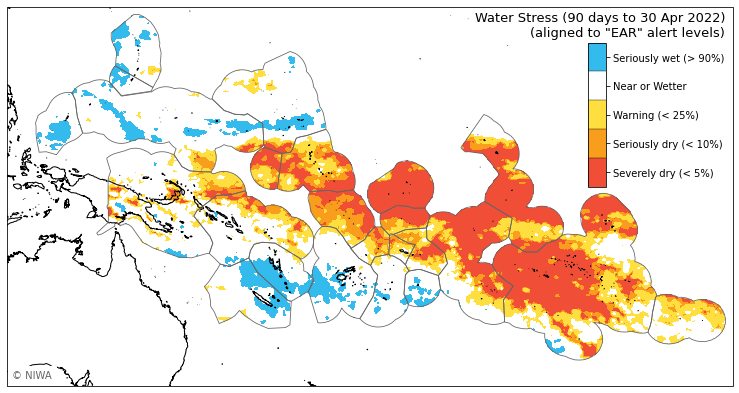

In [23]:
plot.map_EAR_Watch_Pacific(dset_gpm, close=False, mask='EEZ', geoms=EEZs, fpath='/home/nicolasf/Desktop/')

### read the probabilistic forecasts from the GCMs now 

In [24]:
if period == 'seasonal': 
    offset = 3
elif period == 'monthly': 
    offset = 1

### list the files 

In [25]:
dpath_forecasts

PosixPath('/home/nicolasf/operational/ICU/development/hotspots/code/ICU_Water_Watch/outputs/C3S')

In [26]:
lfiles = list(dpath_forecasts.glob(f"{period}_{varfname}_{quantile}s_probabilities_from_{year}-{str(month).zfill(2)}_*.netcdf"))

In [27]:
[f.name for f in lfiles]

['seasonal_tprate_quartiles_probabilities_from_2022-04_ECCC_CanCM4i.netcdf',
 'seasonal_tprate_quartiles_probabilities_from_2022-04_CMCC.netcdf',
 'seasonal_tprate_quartiles_probabilities_from_2022-04_METEO_FRANCE.netcdf',
 'seasonal_tprate_quartiles_probabilities_from_2022-04_NCEP.netcdf',
 'seasonal_tprate_quartiles_probabilities_from_2022-04_ECMWF.netcdf',
 'seasonal_tprate_quartiles_probabilities_from_2022-04_ECCC_GEM_NEMO.netcdf',
 'seasonal_tprate_quartiles_probabilities_from_2022-04_UKMO.netcdf',
 'seasonal_tprate_quartiles_probabilities_from_2022-04_JMA.netcdf',
 'seasonal_tprate_quartiles_probabilities_from_2022-04_DWD.netcdf']

### reads in the probabilities for each GCM 

In [28]:
probs = xr.open_mfdataset(lfiles, concat_dim='GCM', combine='nested', engine='netcdf4') 

In [29]:
probs

,Array,Chunk
Bytes,8.08 MiB,918.84 kiB
Shape,"(9, 4, 1, 3, 81, 121)","(1, 4, 1, 3, 81, 121)"
Count,27 Tasks,9 Chunks
Type,float64,numpy.ndarray


### calculates the average across the GCM dimension 

In [30]:
probs_mean = probs.mean('GCM')

### because of all the numerical approximations, it can happen that the sum (over the `GCM` dimension) ends up slightly over 100 (the errors accumulate over all the dimensions)

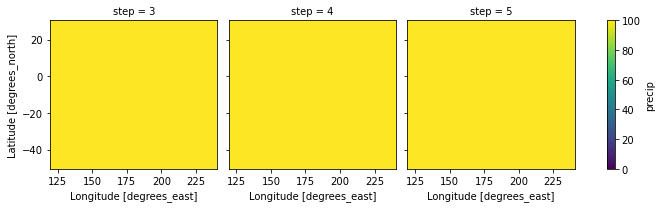

In [31]:
_ = probs_mean.sum(quantile).squeeze()[varname].plot(col='step', vmin=0)

### so we rescale, just in case, if there were not values over 100, it does not change anything 

In [32]:
probs_mean = (probs_mean / probs_mean.sum(quantile)) * 100

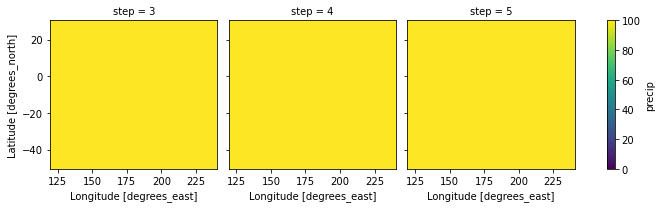

In [33]:
_ = probs_mean.sum(quantile).squeeze()['precip'].plot(col='step', vmin=0)

In [34]:
probs_mean.attrs = probs.attrs

In [35]:
probs_mean

<xarray.Dataset>
Dimensions:   (time: 1, lon: 121, lat: 81, step: 3, quartile: 4)
Coordinates:
  * time      (time) datetime64[ns] 2022-04-01
  * lon       (lon) float32 120.0 121.0 122.0 123.0 ... 237.0 238.0 239.0 240.0
  * lat       (lat) float32 -50.0 -49.0 -48.0 -47.0 ... 27.0 28.0 29.0 30.0
  * step      (step) int64 3 4 5
    month     int64 4
  * quartile  (quartile) int64 1 2 3 4
Data variables:
    precip    (quartile, time, step, lat, lon) float64 dask.array<chunksize=(4, 1, 3, 81, 121), meta=np.ndarray>
Attributes:
    pct_values:  [0.25 0.5  0.75]

### subsets and interpolates on the GPM-IMERG grid 

In [36]:
probs_mean = probs_mean.sel(lon=slice(dset_gpm['lon'].min(), dset_gpm['lon'].max()), lat=slice(dset_gpm['lat'].min(), dset_gpm['lat'].max()))

In [37]:
probs_mean = probs_mean.interp_like(dset_gpm[['lon','lat']], method='linear')

### for the probability for being below a given percentile, we need to get the category (bin) corresponding to this percentile

#### choose the percentile here 

In [38]:
print(" | ".join(map(str, probs_mean.attrs['pct_values'].tolist()))) 

0.25 | 0.5 | 0.75


In [39]:
percentile_bins = probs_mean.attrs['pct_values']

max_cat = np.digitize(pmin / 100, percentile_bins)

### category (bin) corresponding to the 25th percentile

In [40]:
max_cat

1

In [41]:
min_cat = np.digitize(pmin / 100, percentile_bins) + 1

In [42]:
min_cat

2

### probability of being below the given `pmax` percentile (25th percentile)

In [43]:
prob_below = probs_mean.sel({quantile:slice(None, max_cat)}).sum(dim=quantile)

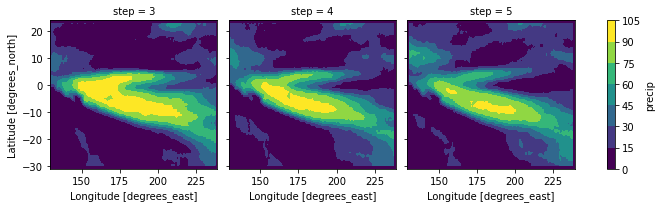

In [44]:
_ = prob_below[varname].plot(levels=10, col='step')

In [45]:
prob_below

<xarray.Dataset>
Dimensions:  (time: 1, step: 3, lat: 220, lon: 439)
Coordinates:
  * time     (time) datetime64[ns] 2022-04-01
  * step     (step) int64 3 4 5
    month    int64 4
  * lat      (lat) float64 -30.88 -30.62 -30.38 -30.12 ... 23.38 23.62 23.88
  * lon      (lon) float64 129.4 129.6 129.9 130.1 ... 238.1 238.4 238.6 238.9
Data variables:
    precip   (time, step, lat, lon) float64 dask.array<chunksize=(1, 3, 220, 439), meta=np.ndarray>

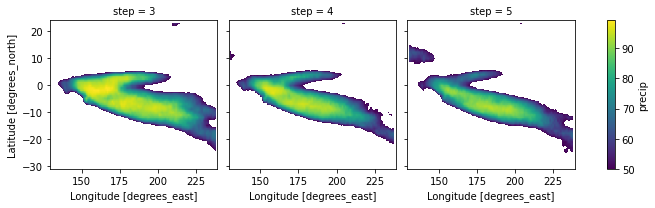

In [46]:
_ = prob_below.where(prob_below >= min_prob)[varname].squeeze().plot(col='step', vmin=min_prob)

### probability for being above the given {pmin} percentile (25th percentile) 

In [47]:
prob_above = probs_mean.sel({quantile:slice(min_cat, None)}).sum(dim=quantile)

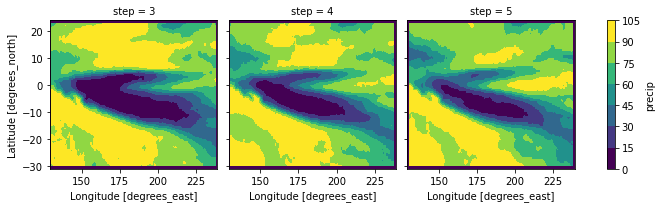

In [48]:
_ = prob_above[varname].plot(levels=10, col='step')

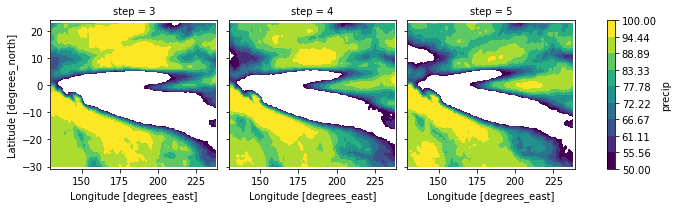

In [49]:
_ = prob_above.where(prob_above >= min_prob)[varname].squeeze().plot.contourf(levels=10, col='step', vmin=min_prob)

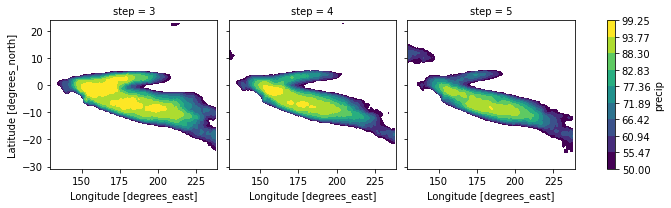

In [50]:
_ = prob_below.where(prob_below >= min_prob)[varname].squeeze().plot.contourf(levels=10, col='step', vmin=min_prob)

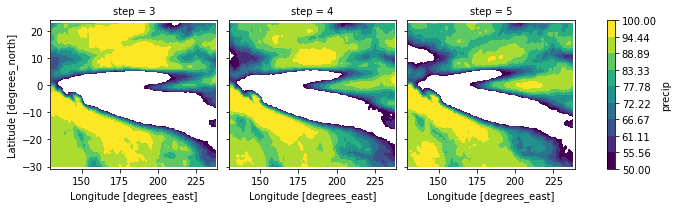

In [51]:
_ = prob_above.where(prob_above >= min_prob)[varname].squeeze().plot.contourf(levels=10, col='step', vmin=min_prob)

### Now rename, and consolidate the forecast probabilities for being below `pmax` (renamed 'B'), above `pmin` (renamed 'A'), and the percentiles of score for GPM (renamed 'GPM') 

In [52]:
prob_below = prob_below.rename({varname:'B'})

In [53]:
prob_above = prob_above.rename({varname:'A'})

In [54]:
gpm = dset_gpm[['pctscore','EEZ']].rename({'pctscore':'GPM'}).squeeze().drop('time')

In [55]:
consolidated_dset = xr.merge([prob_below, prob_above, gpm]) 

In [56]:
consolidated_dset

<xarray.Dataset>
Dimensions:  (time: 1, step: 3, lat: 220, lon: 439)
Coordinates:
  * time     (time) datetime64[ns] 2022-04-01
  * step     (step) int64 3 4 5
    month    int64 4
  * lat      (lat) float64 -30.88 -30.62 -30.38 -30.12 ... 23.38 23.62 23.88
  * lon      (lon) float64 129.4 129.6 129.9 130.1 ... 238.1 238.4 238.6 238.9
Data variables:
    B        (time, step, lat, lon) float64 dask.array<chunksize=(1, 3, 220, 439), meta=np.ndarray>
    A        (time, step, lat, lon) float64 dask.array<chunksize=(1, 3, 220, 439), meta=np.ndarray>
    GPM      (lat, lon) float64 49.0 43.0 26.0 38.0 48.0 ... 10.0 17.0 25.0 20.0
    EEZ      (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan

### HOTSPOT ANALYSIS

quick plot of the probability of being below the 25th percentile

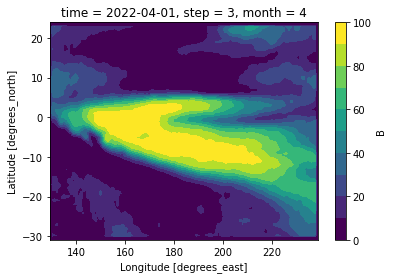

In [57]:
consolidated_dset['B'].squeeze().sel(step=offset).plot.contourf(levels=np.arange(0,110,10))

quick plot of the probability of being above the 25th percentile

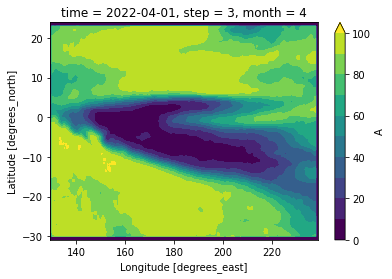

In [58]:
consolidated_dset['A'].squeeze().sel(step=offset).plot.contourf(levels=np.arange(0,110,10))

### FIRST CATEGORY: current water stress conditions, persisting or getting worse 

#### 1st condition, the past 90 days accumulation (variable `GPM`) needs to be below or equal to the 25th percentile 

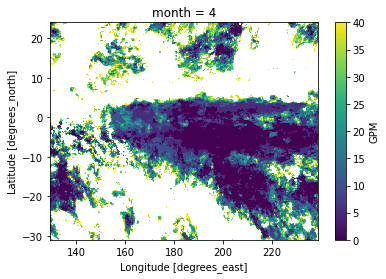

In [59]:
consolidated_dset[['GPM']].where(consolidated_dset['GPM'] <= pmax)['GPM'].plot()

In [60]:
hotspot_1 = consolidated_dset[['B']].where(consolidated_dset['GPM'] <= pmax).squeeze()

#### 2nd condition, next month (forecast, 'B' for below `pmax`) has at least a `min_prob` probability for rainfall being below the 25th percentile 

In [61]:
hotspot_1 = hotspot_1.where(hotspot_1.sel(step=offset) >=  min_prob)

#### the result gets assigned category 1

In [62]:
hotspot_1 = hotspot_1.where(np.isnan(hotspot_1), other=1)

### rename 

In [63]:
hotspot_1 = hotspot_1.rename({'B':'hotspot'})

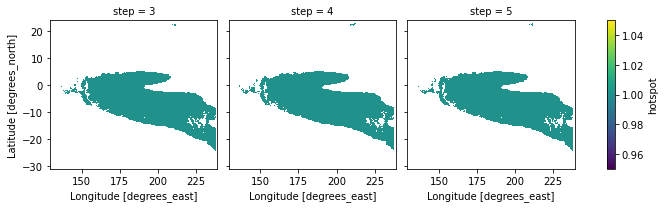

In [64]:
hotspot_1['hotspot'].plot(col='step')

### SECOND CATEGORY: areas moving to water stress conditions  

#### 1st condition: the past 90 days accumulation  (variable `GPM`) needs to be **between** the `pmin` AND `pmax` percentile 

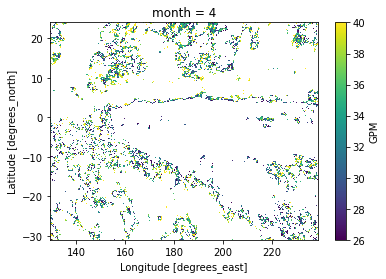

In [65]:
consolidated_dset[['GPM']].where(consolidated_dset['GPM'] <= pmax).where(consolidated_dset['GPM'] > pmin)['GPM'].plot()

In [66]:
hotspot_2 = consolidated_dset[['B']].where(consolidated_dset['GPM'] <= pmax).where(consolidated_dset['GPM'] > pmin).squeeze()

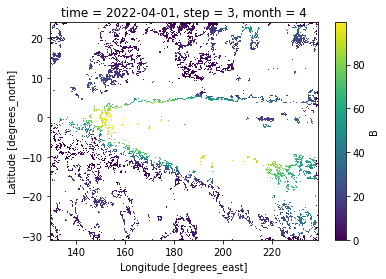

In [67]:
hotspot_2.sel(step=offset)['B'].plot()

#### 2nd condition, next month (forecast, 'B' for below `pmax`) has at least a `min_prob` probability for rainfall being below the 25th percentile 

In [68]:
hotspot_2 = hotspot_2.where(hotspot_2.sel(step=offset) >= min_prob)

#### the result gets assigned category 2

In [69]:
hotspot_2 = hotspot_2.where(np.isnan(hotspot_2), other=2)

### then we rename 

In [70]:
hotspot_2 = hotspot_2.rename({'B':'hotspot'})

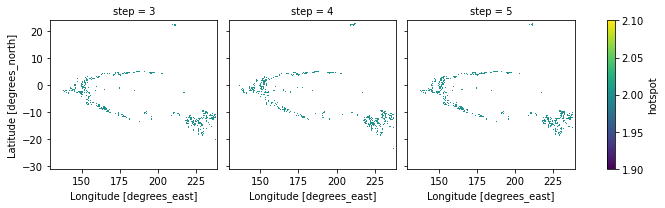

In [71]:
hotspot_2['hotspot'].plot(col='step')

### THIRD CATEGORY: current water stress conditions potentially easing 

#### 1st condition: the past 90 days accumulation needs to be below or equal to the 25th percentile 

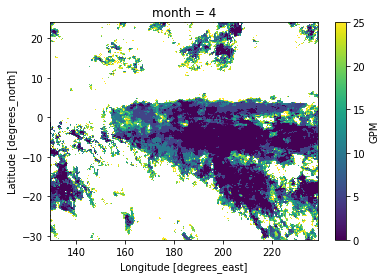

In [72]:
consolidated_dset[['GPM']].where(consolidated_dset['GPM'] <= pmin)['GPM'].plot()

In [73]:
hotspot_3 = consolidated_dset[['A']].where(consolidated_dset['GPM'] <= pmin).squeeze()

#### 2nd condition: next month probability for rainfall being above {pmin} ('A') is above {min_prob}

In [74]:
hotspot_3 = hotspot_3.where(hotspot_3.sel(step=offset) >= min_prob) 

#### the result gets assigned category 2

In [75]:
hotspot_3 = hotspot_3.where(np.isnan(hotspot_3), other=3)

### rename 

In [76]:
hotspot_3 = hotspot_3.rename({'A':'hotspot'})

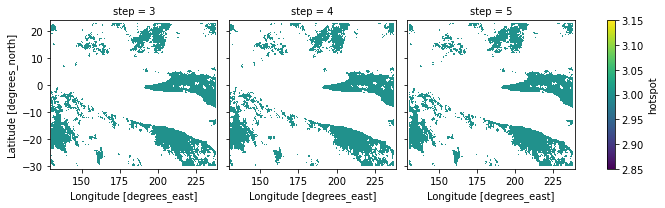

In [77]:
hotspot_3['hotspot'].plot(col='step')

### concatenate along a dummy dimension, calculate the max along this dimension, and optionally selects the domain 

In [78]:
hotspot = xr.concat([hotspot_1, hotspot_2, hotspot_3], dim='category')

In [79]:
hotspot = hotspot.max(dim='category')

In [80]:
hotspot = hotspot.sel(lat=slice(*domain[2:]), lon=slice(*domain[:2]))

/home/nicolasf/mambaforge/envs/ICU_ops/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


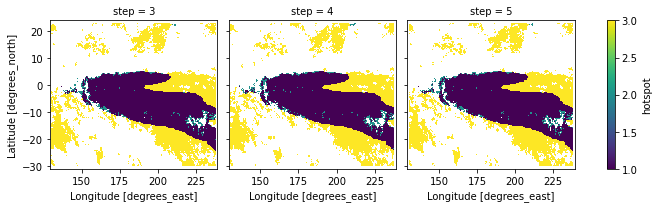

In [81]:
hotspot['hotspot'].plot(col='step')

### adds the mask 

In [82]:
hotspot['mask'] = consolidated_dset['EEZ']

### Now plots 

In [83]:
cbar_kwargs = {}
cbar_kwargs['ticks'] = np.arange(1.5, 4+0.5, 1)
cbar_kwargs['shrink'] = 0.5
cbar_kwargs['orientation'] = 'vertical'
cbar_kwargs['aspect'] = 10

In [84]:
cbar_ticklabels = ['Current water stress\nconditions persisting', 'Areas moving in to\nwater stress conditions', 'Current water stress\nconditions potentially easing']

In [85]:
rgbs = ['#F04E37', '#F99D1C', '#A2D06D']

In [86]:
cmap = matplotlib.colors.ListedColormap(rgbs)

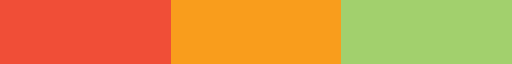

In [87]:
cmap

In [88]:
if period == 'seasonal': 
    plabel = 'season'
elif period == 'monthly': 
    plabel = 'month'

In [89]:
month_name = list(month_name)

In [90]:
month_name += month_name[1:]

### map 

/home/nicolasf/mambaforge/envs/ICU_ops/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


Text(0.0065, 0.02, '© NIWA')

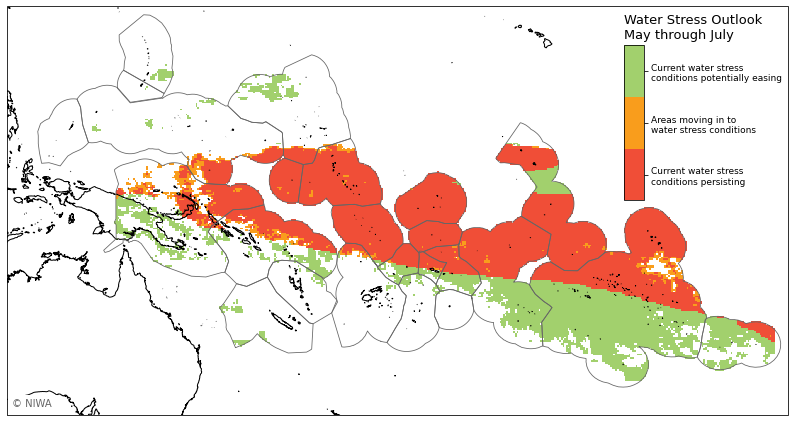

In [91]:
f, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)}, figsize=(14, 8))

im = (hotspot['hotspot'] * hotspot['mask']).sel(step=offset).plot(ax=ax,
                transform=ccrs.PlateCarree(), \
                levels=[1,2,3,4], add_colorbar=False, cmap=cmap)

plot.add_geom(ax, geoms=EEZs)

ax.coastlines(resolution='10m')

cbar_ax = ax.axes.inset_axes([0.79, 0.525, 0.025, 0.38])

cb = plt.colorbar(im, cax=cbar_ax, **cbar_kwargs)

cb.ax.minorticks_off()

cb.ax.set_yticklabels(cbar_ticklabels, fontsize=9)

# plot.make_gridlines(ax, lon_step=20, lat_step=10)

ax.set_title("") 

if period == 'monthly': 
    title = f"Water Stress Outlook\n{month_name[month + 1]}"
elif period == 'seasonal':
    title = f"Water Stress Outlook\n{month_name[month + 1]} through {month_name[month + 3]}"

ax.text(0.79, 0.95, title, fontsize=13, fontdict={'color':'k'}, bbox=dict(facecolor='w', edgecolor='w'), horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)

ax.set_extent(domain, crs = ccrs.PlateCarree())

ax.text(0.0065, 0.02, u'\u00A9'+" NIWA", transform=ax.transAxes, bbox=dict(facecolor='w', edgecolor='w'), fontdict=dict(color='0.4'))

In [92]:
if period == 'seasonal': 
    f.savefig(fpath.joinpath(f'Water_Stress_Outlook_{period}_{year}_{month:02d}_init_{month_name[month + 1]}_{month_name[month + 3]}.png'), dpi=200, facecolor='w', bbox_inches='tight')
elif period == 'monthly': 
    f.savefig(fpath.joinpath(f'Water_Stress_Outlook_{period}_{year}_{month:02d}_init_{month_name[month + 1]}.png'), dpi=200, facecolor='w', bbox_inches='tight')

In [93]:
f.savefig(fpath_web.joinpath(f'Water_Stress_Outlook_{period}_lead{lead}_latest.png'), dpi=200, facecolor='w', bbox_inches='tight')

In [94]:
f.savefig(HOME.joinpath('Desktop').joinpath(f'Water_Stress_Outlook_{period}_lead{lead}_latest.png'), dpi=200, facecolor='w', bbox_inches='tight')